IRD stream
=======================

By using the framework of ``Stream2D``, you can apply functions into multiple fits files.
Here, we try to reduce from raw data to wavelength calibrated spectra.

Start by setting a path for the directory which contains raw data of 'Flat', 'ThAr', and 'Target' (and 'Dark', optionally)

In [1]:
import pathlib
basedir = pathlib.Path('~/pyird/data/20210317/').expanduser()

and some common variables.

In [2]:
band = 'h' #'h' or 'y'
mmf = 'mmf2' #'mmf1' (comb fiber) or 'mmf2' (star fiber)
skipLFC = False #if False, uncertainties are output. mmf1 of y band must be reduced first.

If `skipLFC` is False (default), uncertainties and signal-to-noise ratio at each wavelength are included in output files (*nw?????_m?.dat* and *ncw?????_m?.dat*), computed by using the readout noise (RN) in the comb spectrum (in mmf1) of the Y/J band.
Therefore, spectrum of mmf1 in the Y/J band should be reduced first when `skipLFC=False.`

If `skipLFC=True`, the RN is set by the default value (RN=12 $e^{-}$).

## Preprocessing of calibration dataset

Set the directory and frame numbers for 'Flat'
to search for reference apertures for spectrum extraction.

* It would be better to use FLAT_COMB data (flat light injected to the LFC fiber)
  because lights can be found in both fibers so that there is no need to change frame IDs when switching fiber to analyze.
* Frame numbers can be set the even numbers. When analyzing H band, they are increased by one by using ``fitsid_increment()``.

In [3]:
from pyird.utils import irdstream
## FLAT_COMB
datadir = basedir/'flat/'
anadir = basedir/'reduc/'
flat_comb=irdstream.Stream2D("flat_comb",datadir,anadir)
flat_comb.fitsid=list(range(41704,41804,2)) 

flat_comb.band=band
print(flat_comb.band,' band')

No fitsid yet.
h  band


The function `aptrace` searches apertures to be traced.

* The number of apertures is specified by ``nap``,
  which should be set 42 (or 21) for H band and 102 (or 51) for YJ band.
* The apertures begin its search at ``cutrow``, which is the row number of the detector (wavelength direction),
  and continue in the direction of increasing numbers until it matches the appropriate number of apertures.
  You may as well change the value of ``cutrow`` if the aperture trace is failed.

median combine:  


100%|██████████| 50/50 [00:00<00:00, 106.28it/s]


cross-section: row  1201


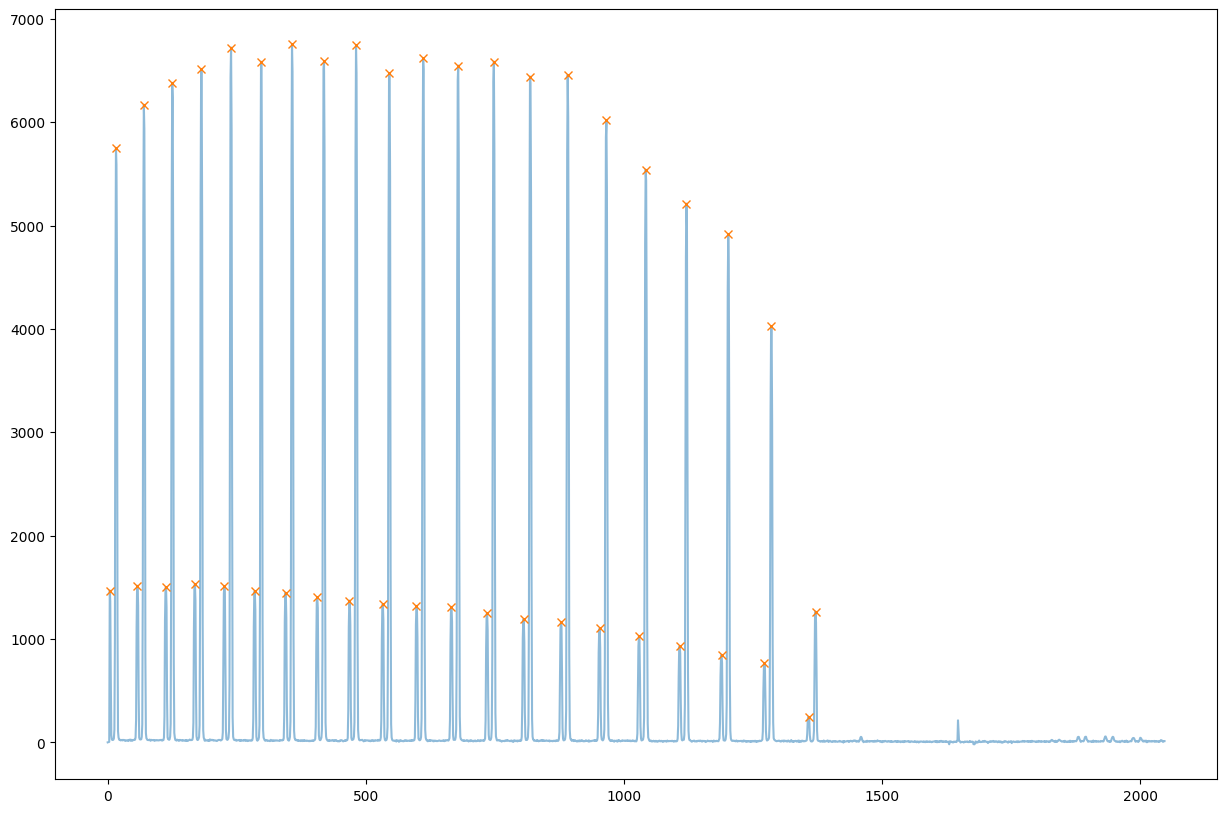

100%|██████████| 42/42 [00:22<00:00,  1.87it/s]


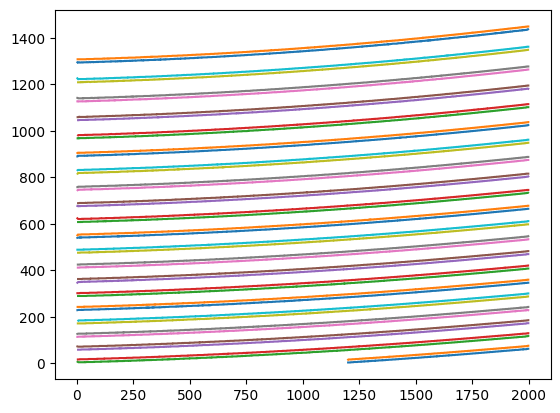

In [4]:
# aperture extraction
if band=='h' and flat_comb.fitsid[0]%2==0:
    flat_comb.fitsid_increment() 
    trace_mmf=flat_comb.aptrace(cutrow = 1200,nap=42) 
elif band=='y':
    trace_mmf=flat_comb.aptrace(cutrow = 1000,nap=102) 

You can change the aperture width if you want.
By default, the width is 6 pixels (from -2 to +4) for IRD data and 5 pixels (from -2 to 3) for REACH data.

For example, setting to 6 pixels (from -2 to +4) can be done as follows:

In [5]:
width_str, width_end = 2, 4
trace_mmf.width = [width_str, width_end]

Show trace mask.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 103.25it/s]


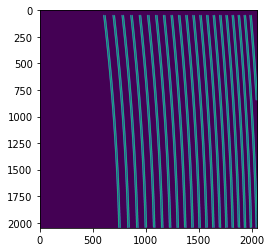

In [6]:
trace_mask = trace_mmf.mask()

import matplotlib.pyplot as plt
# apeture mask plot
plt.imshow(trace_mmf.mask()) 
plt.show()

There are two options for the hotpixel mask:

One is made from dark data as follows.

In [7]:
from pyird.image.bias import bias_subtract_image
from pyird.image.hotpix import identify_hotpix_sigclip

## HOTPIXEL MASK: 
## DARK
datadir = basedir/'dark/'
anadir = basedir/'reduc/'
dark = irdstream.Stream2D('dark', datadir, anadir,fitsid=[43814]) # Multiple file is ok
if band=='h' and dark.fitsid[0]%2==0:
    dark.fitsid_increment() 
median_image = dark.immedian()
im_subbias = bias_subtract_image(median_image)
hotpix_mask = identify_hotpix_sigclip(im_subbias)

fitsid: [43814]
median combine:  


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 110.40it/s]


hotpix mask = 0.45 percent


Another option is reading the prepared hotpixel mask as follows.

In [8]:
# example to read a hotpixel mask used in IRD
import pkg_resources
from pyird.io.read_hotpix import read_hotpix
if band=='h':
    path=pkg_resources.resource_filename('pyird', 'data/hotpix_mask_h_202210_180s.fits')
elif band=='y':
    path=pkg_resources.resource_filename('pyird', 'data/hotpix_mask_y_202210_180s.fits')
hotpix_mask=read_hotpix(path)

Then, select the fiber to analyze.
The following operations are just drop even/odd number of apertures from all apertures identified by Flat.

In [9]:
# reduce mmf1 or mmf2
if mmf=='mmf2':
    trace_mmf.mmf2() #mmf2 (star fiber)
elif mmf=='mmf1':
    trace_mmf.mmf1() #mmf1 (comb fiber)

Wavelength calibration is performed by using reference frames (Thrium-Argon).
We do not need to identify the emission lines by eye;
``calibrate_wavelength`` automatically refer to the line list!

In [10]:
## THAR (ThAr-ThAr)
datadir = basedir/'thar'
anadir = basedir/'reduc'
if band=='h':
    rawtag='IRDAD000'
elif band=='y':
    rawtag='IRDBD000'
#wavelength calibration
thar=irdstream.Stream2D("thar",datadir,anadir,rawtag=rawtag,fitsid=list(range(14632,14732)))
thar.trace = trace_mmf
thar.clean_pattern(trace_mask=trace_mask,extin='', extout='_cp', hotpix_mask=hotpix_mask)
thar.calibrate_wavelength()

fitsid: [14632, 14633, 14634, 14635, 14636, 14637, 14638, 14639, 14640, 14641, 14642, 14643, 14644, 14645, 14646, 14647, 14648, 14649, 14650, 14651, 14652, 14653, 14654, 14655, 14656, 14657, 14658, 14659, 14660, 14661, 14662, 14663, 14664, 14665, 14666, 14667, 14668, 14669, 14670, 14671, 14672, 14673, 14674, 14675, 14676, 14677, 14678, 14679, 14680, 14681, 14682, 14683, 14684, 14685, 14686, 14687, 14688, 14689, 14690, 14691, 14692, 14693, 14694, 14695, 14696, 14697, 14698, 14699, 14700, 14701, 14702, 14703, 14704, 14705, 14706, 14707, 14708, 14709, 14710, 14711, 14712, 14713, 14714, 14715, 14716, 14717, 14718, 14719, 14720, 14721, 14722, 14723, 14724, 14725, 14726, 14727, 14728, 14729, 14730, 14731]
Skipped 100 files because they already exists.


0it [00:00, ?it/s]


median combine:  _cp


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1310.82it/s]
/Users/yuikasagi/miniforge3/envs/py39_pip/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


To reduce the fringe appearing in a spectrum, a process like [``hdsis_ecf''](https://github.com/chimari/hds_iraf) for HDS/Subaru data is applied.
In the preparation of this process, we create the normalized flat by using `apnormalize.`

In [11]:
## FLAT
if mmf=='mmf2':
    ## FLAT_STAR
    datadir = basedir/'flat/'
    anadir = basedir/'reduc/'
    flat_star=irdstream.Stream2D("flat_star",datadir,anadir)
    flat_star.fitsid=list(range(41804,41904,2)) 
    flat_star.trace = trace_mmf
    flat_star.band=band 
    if band == 'h' and flat_star.fitsid[0]%2==0:
        flat_star.fitsid_increment() 
    flat_star.clean_pattern(trace_mask=trace_mask,extin='', extout='_cp', hotpix_mask=hotpix_mask)
    flat_star.imcomb = True # median combine
    flat_star.flatten(hotpix_mask=hotpix_mask)
    df_flatn = flat_star.apnormalize()
elif mmf=='mmf1':
    flat_comb.trace = trace_mmf
    flat_comb.clean_pattern(trace_mask=trace_mask,extin='', extout='_cp', hotpix_mask=hotpix_mask)
    flat_comb.imcomb = True # median combine
    flat_comb.flatten(hotpix_mask=hotpix_mask)
    df_flatn = flat_comb.apnormalize()

No fitsid yet.
Skipped 50 files because they already exists.


0it [00:00, ?it/s]


continuum is fitted with order_fit = 23.
median combine:  _cp


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 408.17it/s]
/Users/yuikasagi/miniforge3/envs/py39_pip/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  3.53it/s]


The preparation of calibration data is now complete!

## Extract target 1D spectrum

From here, we will extract target spectrum.

In [12]:
#--------FOR TARGET--------#
datadir = basedir/'target/'
anadir = basedir/'reduc/'
target = irdstream.Stream2D(
    'targets', datadir, anadir, fitsid=[41510])
if band=='h' and target.fitsid[0]%2==0:
    target.fitsid_increment() # when you use H-band
target.info = True  # show detailed info
target.trace = trace_mmf

fitsid: [41510]


Remove noise pattern on detector by ``clean_pattern``.

In [13]:
# clean pattern
target.clean_pattern(trace_mask=trace_mask,extin='', extout='_cp', hotpix_mask=hotpix_mask)

clean_pattern: output extension= _cp
Ignore  IRDA00041511.fits -> IRDA00041511_cp.fits


0it [00:00, ?it/s]


In ``apext_flatfield``, each order will be extracted with the flat fielding.
The option of ``hotpix_mask`` determines whether hotpixels are masked or not.

In [14]:
# flatten
target.apext_flatfield(df_flatn,hotpix_mask=hotpix_mask)

Ignore  IRDA00041511_cp.fits -> IRDA00041511_flnhp_m2.fits


0it [00:00, ?it/s]


If there is set any hotpixel mask, *IRDA000?????_flnhp.fits* will be created in ``anadir``.

Or, if ``hotpix_mask=None`` (default), *IRDA000?????_fln.fits* will be created in ``anadir``.

Assign wavelength to extracted spectrum.

The option ``extin`` determines whether using the hotpixel masked and flat fielded spectrum (``extin='_flnhp'``) or not (``extin='fln'`` (default)).

dispcor: output spectrum= w41511_m2.dat


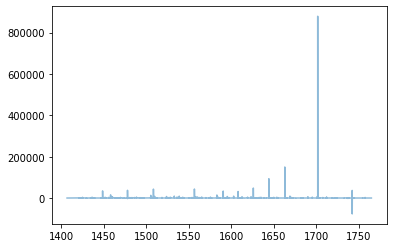

In [15]:
# assign reference spectra & resample
target.dispcor(master_path=thar.anadir,extin='_flnhp')

*w?????_m?.dat* will be created, whose data format is `$1: Wavelength [nm]`, `$2: Order`, `$3: Counts`.

*w?????_m?.dat* reflects the blaze function, so we want to "normalize" the spectra.

The blaze function of each order are created by applying the same aperture extract procedure to Flat image.

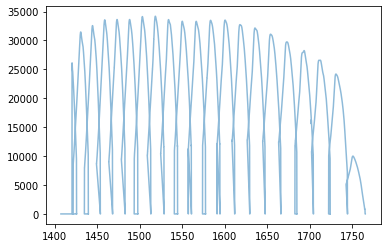

In [16]:
# blaze function
if mmf=='mmf2':
    flat_star.apext_flatfield(df_flatn,hotpix_mask=hotpix_mask)
    flat_star.dispcor(master_path=thar.anadir)
elif mmf=='mmf1':
    flat_comb.apext_flatfield(df_flatn,hotpix_mask=hotpix_mask)
    flat_comb.dispcor(master_path=thar.anadir)

Flat spectrum is now extracted, and *wflat_h_m?.dat* is created.

Then, fit the continuum of the flat spectrum as blaze function and devide target spectrum by them.

Readout Noise is : 7.9305032251889385


/Users/yuikasagi/miniforge3/envs/py39_pip/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/yuikasagi/miniforge3/envs/py39_pip/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


normalize1D: output normalized 1D spectrum= nw41511_m2.dat


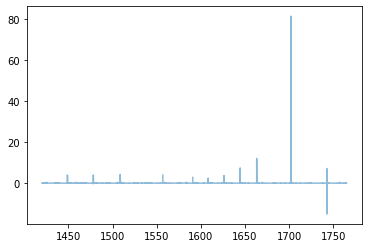

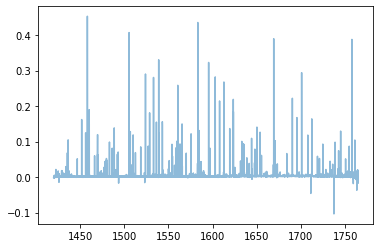

In [17]:
# combine & normalize
if mmf=='mmf2':
    target.normalize1D(master_path=flat_star.anadir,skipLFC=skipLFC)
elif mmf=='mmf1':
    target.normalize1D(master_path=flat_comb.anadir,skipLFC=skipLFC)

After ``normalize1D``, normalized spectrum (*nw?????_m?.dat*) will be created.

The data format is `$1: Wavelength [nm]`, `$2: Order`, `$3: Counts`, `$4: S/N`, `$5: Uncertainties`.

In addition, there will be *ncw?????_m?.dat*, which is the order combined spectrum.

There are overlapping wavelengths at the edge of order, so we "normalize" the spectrum after summing up the flux of that regions to higher signal-to-noise ratio.

The data format is `$1: Wavelength [nm]`, `$2: Counts`, `$3: S/N`, `$4: Uncertainties`.